In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [5]:
import sys; sys.path.append('..')
from typing import List, Tuple

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
from firelab.config import Config

%matplotlib inline

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

from src.models import MaskModel, ConvModel


device = 'cuda:0'


def compute_diff(exp_name, dataset, mask):
    model = load_model_by_hpo_exp_name(exp_name, mask)
    good_idx = model.get_class_idx(1).tolist()
    bad_idx = model.get_class_idx(-1).tolist()
    good_accs = []
    bad_accs = []
    
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)
    
    for batch in dataloader:
        good_accs.extend(compute_values_for_model(model, good_idx, batch)[0])
        bad_accs.extend(compute_values_for_model(model, bad_idx, batch)[0])

    return np.mean(good_accs) - np.mean(bad_accs)


def compute_diff_from_values(values, mask):
    return values[mask == 1].mean() - values[mask == -1].mean()


def compute_mean_values_in_points(model, dataset, mask):
    idx = [(i,j) for i in range(mask.shape[0]) for j in range(mask.shape[1])]
    accs = []
    losses = []
    
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)
    
    for batch in dataloader:
        curr_accs, curr_losses = compute_values_for_model(model, idx, batch)
        accs.append(curr_accs)
        losses.append(curr_losses)
        
    accs = np.array(accs).mean(axis=0)
    losses = np.array(losses).mean(axis=0)
    
    assert accs.size == mask.size
    assert losses.size == mask.size
        
    return accs, losses


def compute_values_for_model(model, mask_idxs, batch):
    accs = []
    losses = []
    criterion = nn.CrossEntropyLoss()
    
    for i, j in mask_idxs:
        x = batch[0].to(device)
        y = batch[1].to(device)

        with torch.no_grad():
            preds = model.run_from_weights(model.compute_point(i,j), x)
            loss = criterion(preds, y).item()
            acc = (preds.argmax(dim=1) == y).float().mean().item()

        accs.append(acc)
        losses.append(loss)
        
    return accs, losses


def load_model(checkpoint_path:os.PathLike, config_path:os.PathLike) -> nn.Module:
    hp = Config.load(config_path).config.hp
    model_builder = lambda: ConvModel(hp.conv_model_config).nn
    model = MaskModel(mask, model_builder, should_center_origin=True, parametrization_type="up_orthogonal")
    model.load_state_dict(torch.load(checkpoint_path))
    model = model.to(device)
    
    return model


def load_model_by_exp_name(exp_name, mask):
    checkpoint_path = f'../experiments/{exp_name}/checkpoints/model-11800.pt'
    config_path = f'../experiments/{exp_name}/summary.yml'
    
    return load_model(checkpoint_path, config_path)


def load_model_by_hpo_exp_name(hpo_exp_name, mask):
    checkpoint_path = f'{exp_dir}/checkpoints/{hpo_exp_name}/model-11800.pt'
    config_path = f'{exp_dir}/summaries/{hpo_exp_name}.yml'
    
    return load_model(checkpoint_path, config_path)

In [7]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_dataset = FashionMNIST('../data', train=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST('../data', train=False, transform=transforms.ToTensor())

train_subset = Subset(train_dataset, list(range(100)))
test_subset = Subset(test_dataset, list(range(100)))

# Plotting examples

In [8]:
mask = np.load('../../loss-patterns/experiments/random-squares-00004/custom_data/mask.npy')
# no_bn_scores_train = np.load('../../loss-patterns/experiments/random-squares-00004/custom_data/minima_grid_train.npy')
# no_bn_scores_test = np.load('../../loss-patterns/experiments/random-squares-00004/custom_data/minima_grid_test.npy')
# bn_scores_train = np.load('../../loss-patterns/experiments/random-squares-00005/custom_data/minima_grid_train.npy')
# bn_scores_test = np.load('../../loss-patterns/experiments/random-squares-00005/custom_data/minima_grid_test.npy')

# no_bn_scores = {
#     'accs_train': no_bn_scores_train[:, :, 1],
#     'accs_test': no_bn_scores_test[:, :, 1],
#     'losses_train': no_bn_scores_train[:, :, 0],
#     'losses_test': no_bn_scores_test[:, :, 0]
# }

# bn_scores = {
#     'accs_train': bn_scores_train[:, :, 1],
#     'accs_test': bn_scores_test[:, :, 1],
#     'losses_train': bn_scores_train[:, :, 0],
#     'losses_test': bn_scores_test[:, :, 0]
# }


def get_scores(exp_name, mask):
    model = load_model_by_exp_name(exp_name, mask)
    accs_train, losses_train = compute_mean_values_in_points(model, train_subset, mask)
    accs_test, losses_test = compute_mean_values_in_points(model, test_subset, mask)

    return {
       'accs_train': np.array(accs_train).reshape(mask.shape),
       'losses_train': np.array(losses_train).reshape(mask.shape),
       'accs_test': np.array(accs_test).reshape(mask.shape),
       'losses_test': np.array(losses_test).reshape(mask.shape),
    }

no_bn_scores = get_scores('random-squares-00004', mask)
bn_scores = get_scores('random-squares-00005', mask)

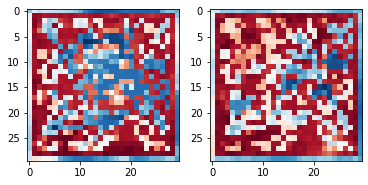

In [9]:
plt.subplot(121)
plt.imshow(no_bn_scores['accs_train'], cmap='RdBu_r')

plt.subplot(122)
plt.imshow(bn_scores['accs_train'], cmap='RdBu_r')

In [10]:
from matplotlib import ticker, cm

def plot_minima(scores, title:str='', colorbar=True, log_scale=False):
    xs = np.linspace(0, 30, 30)
    ys = np.linspace(0, 30, 30)
    X, Y = np.meshgrid(xs, ys)

    if log_scale:
        cntr = plt.contourf(X, Y, scores, locator=ticker.LogLocator(base=2), cmap='RdBu_r',
                           levels=np.logspace(-3, 8, 10, base=2))
    else:
        cntr = plt.contourf(X, Y, scores, cmap='RdBu_r', levels=np.linspace(0, 1, 101))
    
    if colorbar:
        if log_scale:
            cbar = plt.colorbar(cntr, ticks=[0.4, 1, 4, 128])
            cbar.ax.set_yticklabels(['0.4', '1', '4', '>128'])
        else:
            cbar = plt.colorbar(cntr, ticks=np.linspace(0.1, 0.9, 9))
            cbar.ax.set_yticklabels([f'{x:0.1f}' for x in np.linspace(0, 1, 11)])
            
        cbar.ax.tick_params(labelsize=18)
        
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

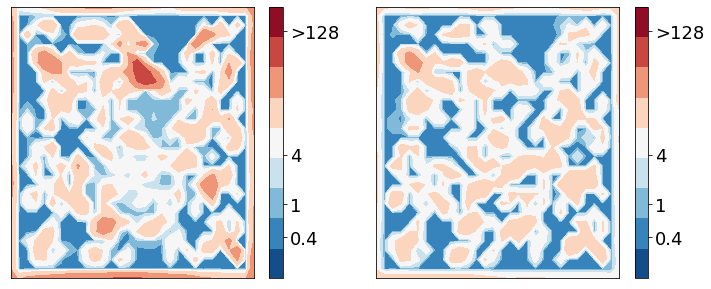

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_minima(no_bn_scores['losses_test'], colorbar=True, log_scale=True)

plt.subplot(122)
plot_minima(bn_scores['losses_test'], colorbar=True, log_scale=True)

In [12]:
mask = np.load('../../loss-patterns/experiments/random-squares-00004/custom_data/mask.npy')
mask[mask == 0] = -1
mask = 1 - mask
fig = plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('../random-squares/mask.png', transparent=True, bbox_inches = 'tight', pad_inches=0)
plt.close(fig)

In [13]:
fig = plt.figure(figsize=(6, 5))
plot_minima(no_bn_scores['losses_test'], colorbar=True, log_scale=True)
#plt.imshow(no_bn_scores['accs_train'], cmap='RdBu_r')
plt.savefig('../random-squares/without-bn.png', transparent = True, bbox_inches = 'tight', pad_inches=0)
plt.close(fig)

fig = plt.figure(figsize=(6, 5))
plot_minima(bn_scores['losses_test'], colorbar=True, log_scale=True)
# plt.imshow(bn_scores['accs_train'], cmap='RdBu_r')
plt.savefig('../random-squares/with-bn.png', transparent = True, bbox_inches = 'tight', pad_inches=0)
plt.close(fig)

# Plotting accuracy diffs

In [ ]:
scores = {}

for i, hpo_exp_name in tqdm(enumerate(exp_names), total=len(exp_names)):
    mask = masks[i]
    model = load_model_by_hpo_exp_name(hpo_exp_name, mask)
    # TODO: use full datasets
    accs_train, losses_train = compute_mean_values_in_points(hpo_exp_name, train_subset, mask)
    accs_test, losses_test = compute_mean_values_in_points(hpo_exp_name, test_subset, mask)

    scores[hpo_exp_name] = {
       'accs_train': np.array(accs_train).reshape(mask.shape),
       'losses_train': np.array(losses_train).reshape(mask.shape),
       'accs_test': np.array(accs_test).reshape(mask.shape),
       'losses_test': np.array(losses_test).reshape(mask.shape),
    }
    #scores[hpo_exp_name] = {
    #   'accs_train': np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_train.npy')[:,:,1],
    #   'losses_train': np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_train.npy')[:,:,0],
    #   'accs_test': np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_test.npy')[:,:,1],
    #   'losses_test': np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_test.npy')[:,:,0],
    #}

    hps.loc[hpo_exp_name, 'acc_diff_train'] = compute_diff_from_values(scores[hpo_exp_name]['accs_train'], mask)
    hps.loc[hpo_exp_name, 'loss_diff_train'] = compute_diff_from_values(scores[hpo_exp_name]['losses_train'], mask)
    hps.loc[hpo_exp_name, 'acc_diff_test'] = compute_diff_from_values(scores[hpo_exp_name]['accs_test'], mask)
    hps.loc[hpo_exp_name, 'loss_diff_test'] = compute_diff_from_values(scores[hpo_exp_name]['losses_test'], mask)

In [ ]:
exp_dir = '../experiments/random-squares-00003'
logs_export_dir = '../logs_export/random-squares-00003/'

val_acc_diffs = pd.read_csv(f'{logs_export_dir}/val_acc_diffs.csv', index_col=0)
hps = pd.read_csv(f'{logs_export_dir}/hps.csv', index_col=0)
# summaries = [Config.load(f'{exp_dir}/summaries/{exp_name}.yml') for exp_name in hps.index.values]
masks = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/mask.npy') for hpo_exp_name in hps.index.values]
minima_grid_train = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_train.npy') for hpo_exp_name in hps.index.values]
minima_grid_test = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_test.npy') for hpo_exp_name in hps.index.values]

In [6]:
for i, hpo_exp_name in enumerate(hps.index.values):
    mask = masks[i]
    hps.loc[hpo_exp_name, 'mean_good_acc_test'] = scores[hpo_exp_name]['accs_test'][mask == 1].mean()
    hps.loc[hpo_exp_name, 'mean_bad_acc_test'] = scores[hpo_exp_name]['accs_test'][mask == -1].mean()    

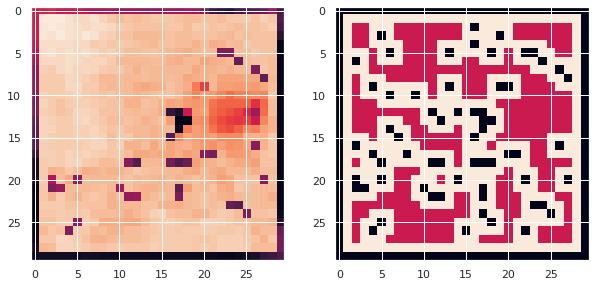

In [7]:
i = 120

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(scores[hps.index.values[i]]['accs_test'])
plt.subplot(122)
plt.imshow(masks[i])

In [8]:
def get_model_type_from_config(model_config_str):
    if "'use_bn': True" in model_config_str:
        return 'with_bn'
    elif "'use_skip_connection': True" in model_config_str:
        return 'with_skip_connection'
    else:
        return 'simple'

hps['model_type'] = hps['conv_model_config'].apply(get_model_type_from_config)

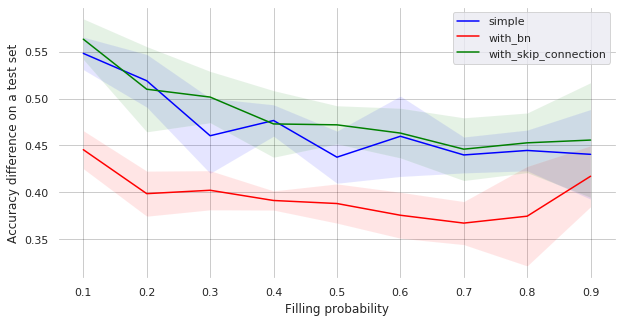

In [15]:
# import seaborn as sns
# sns.reset_orig()

# plt.rcParams['figure.facecolor'] = 'white'
# plt.style.use("ggplot")

fill_probs = hps[hps['model_type'] == 'simple'].groupby('fill_prob')['acc_diff_test'].mean().index.values
plt.figure(figsize=(10, 5))
plt.grid(color='black', alpha=0.2)
# plt.style.use('ggplot')
# sns.lineplot(x="fill_prob", y="acc_diff_test", hue='has_batch_normalization', data=hps[hps['model_type'] != 'with_skip_connection'], ci="sd");

for model_type, color in [('simple', 'blue'), ('with_bn', 'red'), ('with_skip_connection', 'green')]:
    mean = hps[hps['model_type'] == model_type].groupby('fill_prob')['acc_diff_test'].mean().values
    std = hps[hps['model_type'] == model_type].groupby('fill_prob')['acc_diff_test'].std().values

    plt.fill_between(fill_probs, mean + std, mean - std, facecolor=color, alpha=0.1)
    plt.plot(fill_probs, mean, label=model_type, color=color)

plt.xticks(fill_probs, fill_probs)
plt.ylabel('Accuracy difference on a test set')
plt.xlabel('Filling probability')
plt.legend()
plt.gca().set_facecolor("white")

# import tikzplotlib

# tikzplotlib.save('../batch_norm_acc_diff.tex')

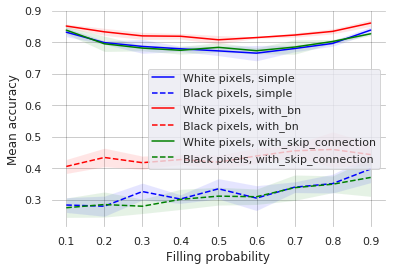

In [16]:
# plt.figure(figsize=(6, 4))
plt.grid(color='black', alpha=0.2)

for model_type, color in [('simple', 'blue'), ('with_bn', 'red'), ('with_skip_connection', 'green')]:
    good_mean = hps[hps['model_type'] == model_type].groupby('fill_prob')['mean_good_acc_test'].mean().values
    good_std = hps[hps['model_type'] == model_type].groupby('fill_prob')['mean_good_acc_test'].std().values
    
    plt.fill_between(fill_probs, good_mean + good_std, good_mean - good_std, facecolor=color, alpha=0.1)
    plt.plot(fill_probs, good_mean, label=f'White pixels, {model_type}', color=color)

    bad_mean = hps[hps['model_type'] == model_type].groupby('fill_prob')['mean_bad_acc_test'].mean().values
    bad_std = hps[hps['model_type'] == model_type].groupby('fill_prob')['mean_bad_acc_test'].std().values
    
    plt.fill_between(fill_probs, bad_mean + bad_std, bad_mean - bad_std, facecolor=color, alpha=0.1)
    plt.plot(fill_probs, bad_mean, label=f'Black pixels, {model_type}', color=color, linestyle='--')

plt.ylabel('Mean accuracy')
plt.xlabel('Filling probability')
plt.legend()
plt.gca().set_facecolor("white")

# tikzplotlib.save('../mean_accs.tex')

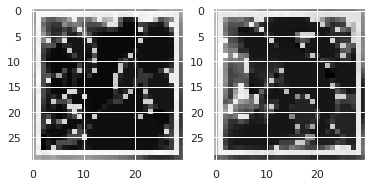

In [17]:
plt.subplot(121)
plt.imshow(scores['hpo-experiment-00000']['accs_test'], cmap='gray')

plt.subplot(122)
plt.imshow(scores['hpo-experiment-00001']['accs_test'], cmap='gray')

In [9]:
from skimage.io import imread
from skimage.transform import resize
from src.trainers.mask_trainer import convert_img_to_binary

icon = imread('../data/main-icons/duck-side-view-outline.png')
icon = resize(icon, (50, 50), mode='constant', anti_aliasing=True)
icon = convert_img_to_binary(icon)
# icon = 1 - icon

/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

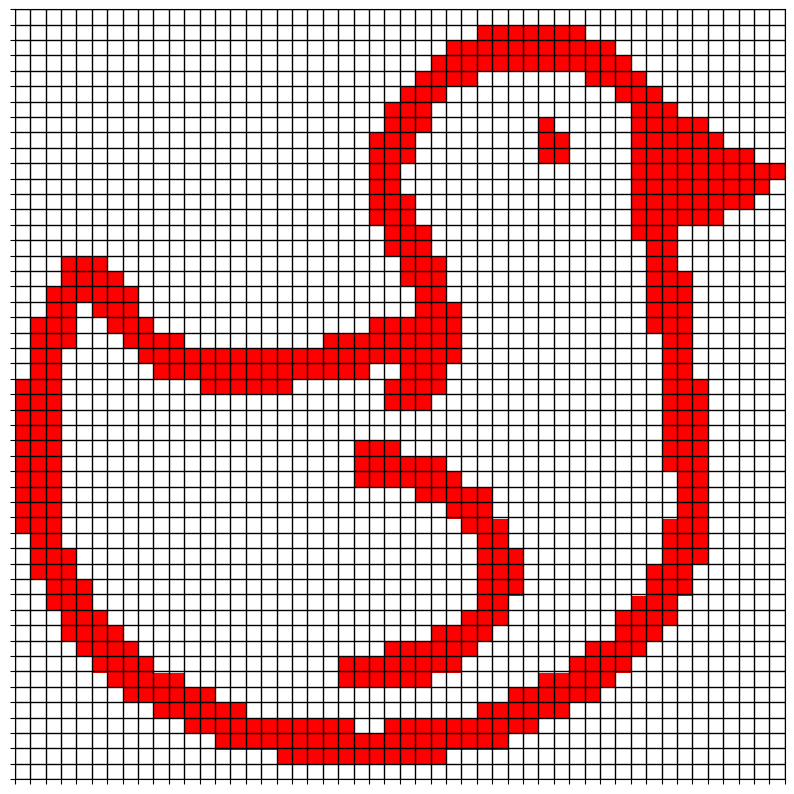

In [10]:
import matplotlib

# sns.set_style('white')
sns.reset_orig()
plt.figure(figsize=(10, 10))
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "white"],
          [norm(-0.6), "lightgrey"],
          [norm( 0.6), "lightgrey"],
          [norm( 1.0), "red"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
plt.imshow(icon, cmap=cmap, interpolation='nearest')

ticks = np.arange(-1, icon.shape[0])
line_width = 0.2

ax = plt.gca()
ax.set_xlim(-ticks[0] - 1, ticks[-1])
ax.set_ylim(ticks[-1], -ticks[0] - 1)
ax.set_xticks([t + 0.5 for t in ticks])
ax.set_yticks([t + 0.4 for t in ticks])
# ax.set_xticklabels([i if i % 5 == 0 else "" for i in ticks])
# ax.set_yticklabels([i if i % 5 == 0 else "" for i in ticks])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='both', color='#000000', linewidth=1)